In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, DateType, DoubleType
from pyspark.sql import functions
import math
import plotly.offline as pyo
import plotly.graph_objs as go

In [15]:
spark = SparkSession \
    .builder \
    .appName("airlinedelay") \
    .getOrCreate()

context = spark.sparkContext

In [16]:
schema = StructType([
    StructField("FL_DATE", DateType(), True),
    StructField("OP_CARRIER", StringType(), True),
    StructField("OP_CARRIER_FL_NUM", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("CRS_DEP_TIME", DoubleType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", DoubleType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("CARRIER_DELAY", DoubleType(), True),
    StructField("WEATHER_DELAY", DoubleType(), True),
    StructField("NAS_DELAY", DoubleType(), True),
    StructField("SECURITY_DELAY", DoubleType(), True),
    StructField("LATE_AIRCRAFT_DELAY", DoubleType(), True)
])

df = spark.read.format("csv") \
    .option("sep", ",") \
    .option("header", True) \
    .schema(schema) \
    .load("*.csv")

df.createOrReplaceTempView("airlinedelay")

CORRELATION BETWEEN DEPARTURE DELAY AND ARRIVAL DELAY

In [ ]:
df.stat.corr('DEP_DELAY', 'ARR_DELAY')

GENERAL EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS

In [ ]:
evolutionAverageDelaysPerYear = spark.sql("SELECT EXTRACT(year from FL_DATE) AS Year, AVG(IF(DEP_DELAY > 0, DEP_DELAY, NULL)) AS AverageDepartureDelayPerYear, AVG(IF(DEP_DELAY < 0, DEP_DELAY, NULL)) AS AverageDepartureImmediacyPerYear, AVG(IF(ARR_DELAY > 0, ARR_DELAY, NULL)) AS AverageArrivalDelayPerYear, AVG(IF(ARR_DELAY < 0, ARR_DELAY, NULL)) AS AverageArrivalImmediacyPerYear \
    FROM airlinedelay \
    GROUP BY Year") \
    
evolutionAverageDelaysPerYear.show()

GENERAL EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS \[GRAPHS\]

In [ ]:
averageDepartureDelayPerYearTrace = go.Scatter(
    y = evolutionAverageDelaysPerYear.toPandas()['AverageDepartureDelayPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Departure Delay',
    marker = dict(color='red'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

averageArrivalDelayPerYearTrace = go.Scatter(
    y = evolutionAverageDelaysPerYear.toPandas()['AverageArrivalDelayPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Arrival Delay',
    marker = dict(color='yellow'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

data = [averageDepartureDelayPerYearTrace, averageArrivalDelayPerYearTrace]

layout = dict(title = 'Evolution Of Average Delay Year-over-Year',
              xaxis= dict(title= 'Years',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Average Delay (Minutes)')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

In [ ]:
averageDepartureImmediacyPerYearTrace = go.Scatter(
    y= evolutionAverageDelaysPerYear.toPandas()['AverageDepartureImmediacyPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Departure Haste',
    marker = dict(color='blue'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

averageArrivalImmediacyPerYearTrace = go.Scatter(
    y = evolutionAverageDelaysPerYear.toPandas()['AverageArrivalImmediacyPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Arrival Haste',
    marker = dict(color='green'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

data = [averageDepartureImmediacyPerYearTrace, averageArrivalImmediacyPerYearTrace]

layout = dict(title = 'Evolution Of Average Haste Year-over-Year',
              xaxis= dict(title= 'Year',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Average Haste (Minutes)')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

AVERAGE DEPARTURE/ARRIVAL DELAYS AND IMMEDIACIES FOR EACH CARRIER

In [ ]:
spark.sql("SELECT OP_CARRIER AS Carrier, AVG(IF(DEP_DELAY > 0, DEP_DELAY, NULL)) AS AverageDepartureDelayPerYear, AVG(IF(DEP_DELAY < 0, DEP_DELAY, NULL)) AS AverageDepartureImmediacyPerYear, AVG(IF(ARR_DELAY > 0, ARR_DELAY, NULL)) AS AverageArrivalDelayPerYear, AVG(IF(ARR_DELAY < 0, ARR_DELAY, NULL)) AS AverageArrivalImmediacyPerYear \
    FROM airlinedelay \
    GROUP BY OP_CARRIER \
    ORDER BY OP_CARRIER") \
    .show(1000)

EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS PER CARRIER FOR EACH YEAR

In [ ]:
carrierDelayEvolution = spark.sql("SELECT OP_CARRIER AS Carrier, EXTRACT(year from FL_DATE) AS Year, AVG(IF(DEP_DELAY > 0, DEP_DELAY, NULL)) AS AverageDepartureDelayPerYear, AVG(IF(DEP_DELAY < 0, DEP_DELAY, NULL)) AS AverageDepartureImmediacyPerYear, AVG(IF(ARR_DELAY > 0, ARR_DELAY, NULL)) AS AverageArrivalDelayPerYear, AVG(IF(ARR_DELAY < 0, ARR_DELAY, NULL)) AS AverageArrivalImmediacyPerYear \
    FROM airlinedelay \
    GROUP BY OP_CARRIER, Year  \
    ORDER BY OP_CARRIER, Year")

carrierDelayEvolution.show(1000)

In [ ]:
carrierDelayEvolution.createOrReplaceTempView("carrierDelayEvolution")

EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS PER CARRIER FOR EACH YEAR: absolute change YoY of average departure/arrival delays/immediacies 

*Note: negative => immediacy decreases, plane leaves on time; positive => immediacy increases, plane does not leave on time.*

In [ ]:
spark.sql(" \
    SELECT Carrier, Year, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), AverageDepartureDelayPerYear - LAG(AverageDepartureDelayPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageDepartureDelayYearOverYearDifference, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), - AverageDepartureImmediacyPerYear + LAG(AverageDepartureImmediacyPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageDepartureImmediacyYearOverYearDifference, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), AverageArrivalDelayPerYear - LAG(AverageArrivalDelayPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageArrivalDelayYearOverYearDifference, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), - AverageArrivalImmediacyPerYear + LAG(AverageArrivalImmediacyPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageArrivalImmediacyYearOverYearDifference \
    FROM carrierDelayEvolution") \
    .na.drop('any') \
    .show(1000)

# TODO: graphs for the cells above, related to evolution of delay amount and stuff

PERCENTAGE OF DELAYS/IMMEDIACIES ON DELAYS/ARRIVALS PER CARRIER FOR ENTIRE PERIOD RELATIVE TO ALL FLIGHTS FOR CURRENT CARRIER

In [ ]:
numberOfDelaysPerCarrier = spark.sql(" \
    SELECT OP_CARRIER AS Carrier, \
    SUM( \
          CASE WHEN DEP_DELAY > 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS DepartureDelayCount, \
    SUM( \
          CASE WHEN ARR_DELAY > 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS ArrivalDelayCount, \
    SUM( \
          CASE WHEN DEP_DELAY < 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS DepartureImmediaciesCount, \
    SUM( \
          CASE WHEN ARR_DELAY < 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS ArrivalImmediaciesCount \
    FROM airlinedelay \
    GROUP BY Carrier")

numberOfDelaysPerCarrier.show(1000)

PERCENTAGE OF DELAYS/IMMEDIACIES ON DELAYS/ARRIVALS PER CARRIER FOR ENTIRE PERIOD RELATIVE TO ALL FLIGHTS FOR CURRENT CARRIER \[GRAPHS\]

In [ ]:
departureDelayCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['DepartureDelayCount'],
    name = 'Departure Delay Percentage',
    marker = dict(color='red'),
    text = round(numberOfDelaysPerCarrier.toPandas()['DepartureDelayCount'] * 100))

arrivalDelayCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['ArrivalDelayCount'],
    name = 'Arrival Delay Percentage',
    marker = dict(color='yellow'),
    text = round(numberOfDelaysPerCarrier.toPandas()['ArrivalDelayCount'] * 100))

departureImmediaciesCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['DepartureImmediaciesCount'],
    name = 'Departure Haste Percentage',
    marker = dict(color='blue'),
    text = round(numberOfDelaysPerCarrier.toPandas()['DepartureImmediaciesCount'] * 100))

arrivalImmediaciesCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['ArrivalImmediaciesCount'],
    name = 'Arrival Immediacies Percentage',
    marker = dict(color='green'),
    text = round(numberOfDelaysPerCarrier.toPandas()['ArrivalImmediaciesCount'] * 100))


data = [departureDelayCountBar, arrivalDelayCountBar, departureImmediaciesCountBar, arrivalImmediaciesCountBar]

layout = dict(title = 'Departure and Arrival Delay or Haste Percentage Relative to Flight Count per Carrier for Entire Period',
              xaxis= dict(title= 'Carrier',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Percentage of Flights',tickformat=',.0%')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

DELAY CORRECTIONS COUNT PER CARRIER ACROSS THE ENTIRE PERIOD RELATIVE TO DELAYED FLIGHTS COUNT PER CARRIER

In [ ]:
totalDelayCorrectionsCount = spark.sql(" \
    SELECT OP_CARRIER AS Carrier, \
    SUM( \
          CASE WHEN DEP_DELAY = ARR_DELAY THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS NoDelayCorrectionCount, \
    SUM( \
          CASE WHEN ARR_DELAY = (DEP_DELAY * -1) THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS FullDelayCorrectionCount, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY < DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY > DEP_DELAY) THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS PartialDelayCorrectionCount, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY > DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY < 0 AND ABS(DEP_DELAY) < ABS(ARR_DELAY)) THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS DelayAggravationCount \
    FROM airlinedelay \
    WHERE DEP_DELAY != 0 \
    GROUP BY Carrier")
    
totalDelayCorrectionsCount.show(1000)

DELAY CORRECTIONS COUNT PER CARRIER ACROSS THE ENTIRE PERIOD RELATIVE TO DELAYED FLIGHTS COUNT PER CARRIER \[GRAPH\]

In [ ]:
noDelayCorrectionCountBar = go.Bar(
    x = totalDelayCorrectionsCount.toPandas()['Carrier'],
    y = totalDelayCorrectionsCount.toPandas()['NoDelayCorrectionCount'],
    name = 'No Delay Correction Count',
    marker = dict(color='yellow'),
    text = round(totalDelayCorrectionsCount.toPandas()['NoDelayCorrectionCount'] * 100))

delayAggravationCountBar = go.Bar(
    x = totalDelayCorrectionsCount.toPandas()['Carrier'],
    y = totalDelayCorrectionsCount.toPandas()['DelayAggravationCount'],
    name = 'Delay Aggravation Count',
    marker = dict(color='red'),
    text = round(totalDelayCorrectionsCount.toPandas()['DelayAggravationCount'] * 100))

fullDelayCorrectionCount = go.Bar(
    x = totalDelayCorrectionsCount.toPandas()['Carrier'],
    y = totalDelayCorrectionsCount.toPandas()['FullDelayCorrectionCount'],
    name = 'Full Delay Correction Count',
    marker = dict(color='green'),
    text = round(totalDelayCorrectionsCount.toPandas()['FullDelayCorrectionCount'] * 100))

partialDelayCorrectionCount = go.Bar(
    x = totalDelayCorrectionsCount.toPandas()['Carrier'],
    y = totalDelayCorrectionsCount.toPandas()['PartialDelayCorrectionCount'],
    name = 'Partial Delay Correction Count',
    marker = dict(color='blue'),
    text = round(totalDelayCorrectionsCount.toPandas()['PartialDelayCorrectionCount'] * 100))


data = [noDelayCorrectionCountBar, delayAggravationCountBar, fullDelayCorrectionCount, partialDelayCorrectionCount]

layout = dict(title = 'Delay Correction Relative to Flight Count per Carrier for Entire Period',
              xaxis= dict(title= 'Carrier',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Percentage of Flights',tickformat=',.0%')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

EVOLUTION OF DELAY CORRECTIONS COUNT RELATIVE TO FLIGHT COUNT PER CARRIER ACROSS INDIVIDUAL YEARS

In [17]:
carrierDelayCountEvolution = spark.sql(" \
    SELECT OP_CARRIER AS Carrier, EXTRACT(year from FL_DATE) AS Year, \
    SUM( \
          CASE WHEN DEP_DELAY = ARR_DELAY THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS NoDelayCorrection, \
    SUM( \
          CASE WHEN ARR_DELAY = (DEP_DELAY * -1) THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS FullDelayCorrection, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY < DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY > DEP_DELAY) THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS PartialDelayCorrection, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY > DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY < 0 AND ABS(DEP_DELAY) < ABS(ARR_DELAY)) THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS DelayAggravation \
    FROM airlinedelay \
    GROUP BY Carrier, Year \
    ORDER BY Carrier, Year")
    
carrierDelayCountEvolution.createOrReplaceTempView("carrierDelayCountEvolution")
carrierDelayCountEvolution.show(1000)

+-------+----+--------------------+--------------------+----------------------+-------------------+
|Carrier|Year|   NoDelayCorrection| FullDelayCorrection|PartialDelayCorrection|   DelayAggravation|
+-------+----+--------------------+--------------------+----------------------+-------------------+
|     9E|2013|0.029160670169632055|0.011644719768386356|    0.3494696681170606| 0.5630786549421809|
|     AA|2012| 0.03207417843951106|0.016177982559689275|   0.40690567762080654| 0.4874909561707475|
|     AA|2013| 0.02739216681446613|0.015062531256332603|   0.43746781411103736|0.46156749229862554|
|     AA|2014| 0.03336265591959784|0.015099582106651143|   0.42033152500385906|0.48434341273988885|
|     AS|2012| 0.03678279313405932|0.014040889346678503|    0.3843422399013343| 0.5271296817082178|
|     AS|2013| 0.03965930607523442|0.017422435909863452|   0.44384560206277507|0.46821504042186074|
|     AS|2014| 0.03911217606719207|0.017278496415133193|    0.4485482693423688| 0.4620078998109287|


EVOLUTION OF DELAY CORRECTIONS COUNT RELATIVE TO FLIGHT COUNT PER CARRIER ACROSS INDIVIDUAL YEARS: No Delay Correction

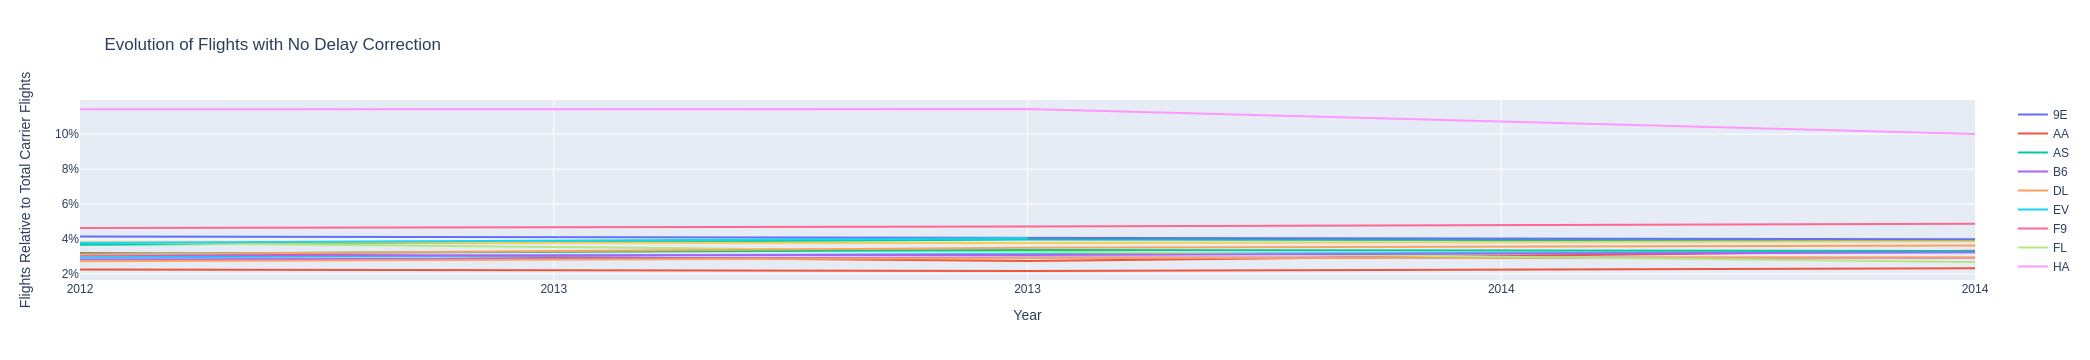

In [34]:
traces = []
changePerCarrierMap = dict()
years = []

for i in range(len(carrierDelayCountEvolution.toPandas()['Year'])):
    if not carrierDelayCountEvolution.toPandas()['Year'][i] in years:
        years.append(carrierDelayCountEvolution.toPandas()['Year'][i])

years.sort()
        
for i in range(len(carrierDelayCountEvolution.toPandas()['Carrier'])):
    if not carrierDelayCountEvolution.toPandas()['Carrier'][i] in changePerCarrierMap:
        changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]] = []
        
    changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]].append(carrierDelayCountEvolution.toPandas()['NoDelayCorrection'][i])
    
for key in changePerCarrierMap:
    traces.append(go.Scatter(
        y = changePerCarrierMap[key],
        x = years,
        mode = 'lines',
        name = key))
                  
layout = dict(title = 'Evolution of Flights with No Delay Correction',
              xaxis= dict(title= 'Year',zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Flights Relative to Total Carrier Flights',tickformat=',.0%')
             )

fig = dict(data = traces, layout = layout)

pyo.iplot(fig)

EVOLUTION OF DELAY CORRECTIONS COUNT RELATIVE TO FLIGHT COUNT PER CARRIER ACROSS INDIVIDUAL YEARS: Full Delay Correction

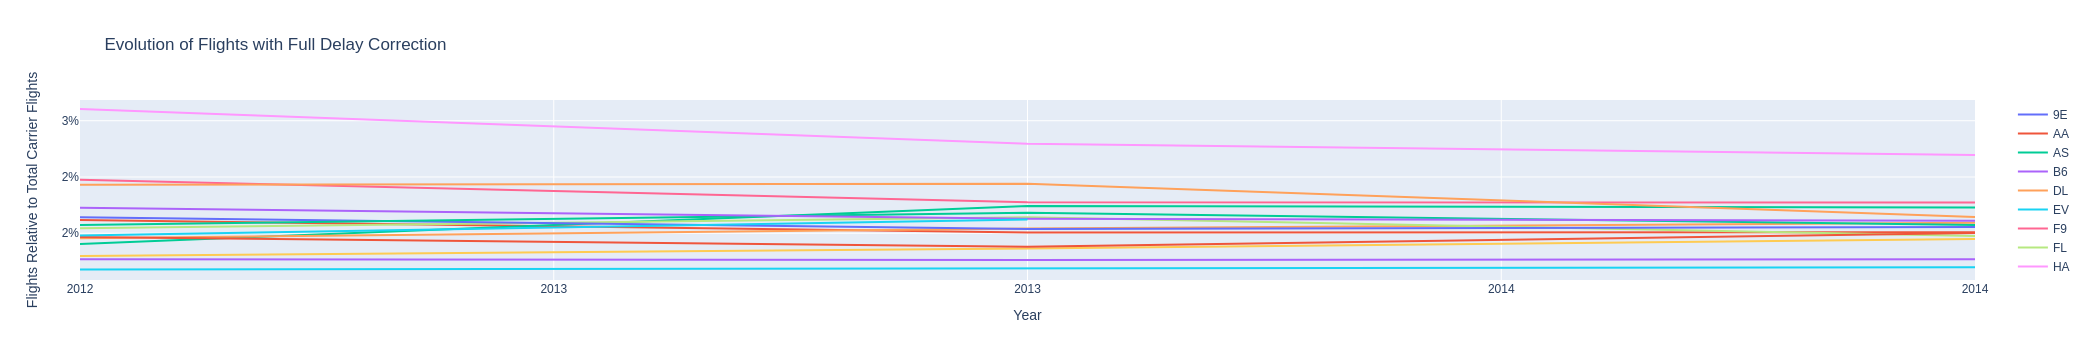

In [39]:
traces = []
changePerCarrierMap = dict()
years = []

for i in range(len(carrierDelayCountEvolution.toPandas()['Year'])):
    if not carrierDelayCountEvolution.toPandas()['Year'][i] in years:
        years.append(carrierDelayCountEvolution.toPandas()['Year'][i])

years.sort()
        
for i in range(len(carrierDelayCountEvolution.toPandas()['Carrier'])):
    if not carrierDelayCountEvolution.toPandas()['Carrier'][i] in changePerCarrierMap:
        changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]] = []
        
    changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]].append(carrierDelayCountEvolution.toPandas()['FullDelayCorrection'][i])
    
for key in changePerCarrierMap:
    traces.append(go.Scatter(
        y = changePerCarrierMap[key],
        x = years,
        mode = 'lines',
        name = key))
                
layout = dict(title = 'Evolution of Flights with Full Delay Correction',
              xaxis= dict(title= 'Year',zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Flights Relative to Total Carrier Flights',tickformat=',.0%')
             )

fig = dict(data = traces, layout = layout)

pyo.iplot(fig)

EVOLUTION OF DELAY CORRECTIONS COUNT RELATIVE TO FLIGHT COUNT PER CARRIER ACROSS INDIVIDUAL YEARS: Partial Delay Correction

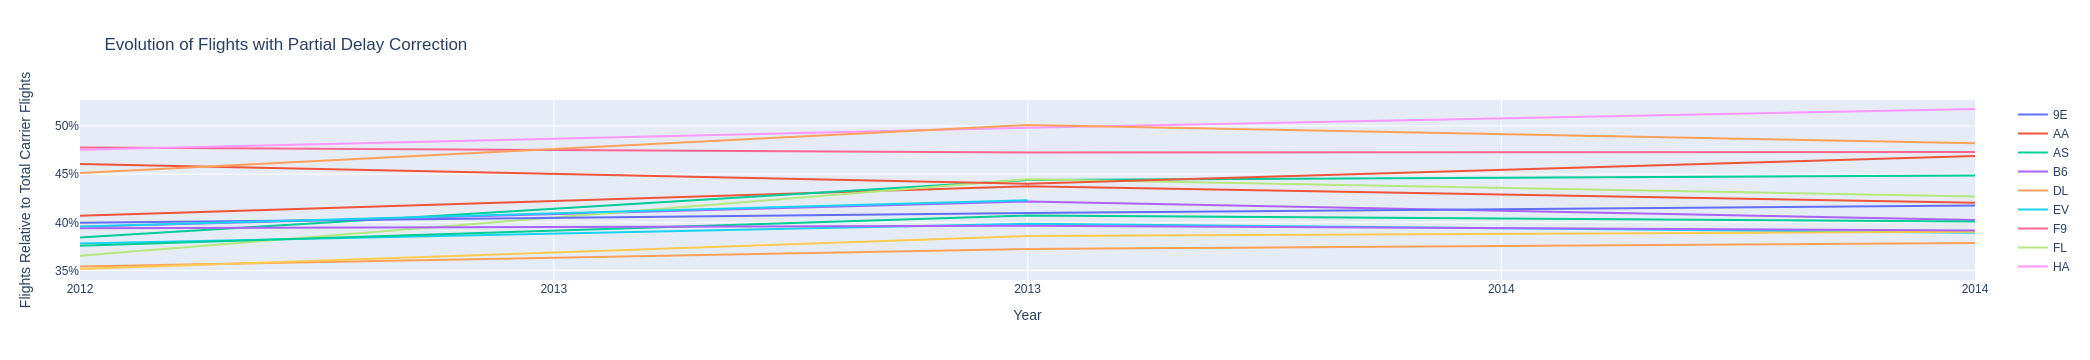

In [38]:
traces = []
changePerCarrierMap = dict()
years = []

for i in range(len(carrierDelayCountEvolution.toPandas()['Year'])):
    if not carrierDelayCountEvolution.toPandas()['Year'][i] in years:
        years.append(carrierDelayCountEvolution.toPandas()['Year'][i])

years.sort()
        
for i in range(len(carrierDelayCountEvolution.toPandas()['Carrier'])):
    if not carrierDelayCountEvolution.toPandas()['Carrier'][i] in changePerCarrierMap:
        changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]] = []
        
    changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]].append(carrierDelayCountEvolution.toPandas()['PartialDelayCorrection'][i])
    
for key in changePerCarrierMap:
    traces.append(go.Scatter(
        y = changePerCarrierMap[key],
        x = years,
        mode = 'lines',
        name = key))
       
layout = dict(title = 'Evolution of Flights with Partial Delay Correction',
              xaxis= dict(title= 'Year',zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Flights Relative to Total Carrier Flights',tickformat=',.0%')
             )

fig = dict(data = traces, layout = layout)

pyo.iplot(fig)

EVOLUTION OF DELAY CORRECTIONS COUNT RELATIVE TO FLIGHT COUNT PER CARRIER ACROSS INDIVIDUAL YEARS: Delay Aggravation

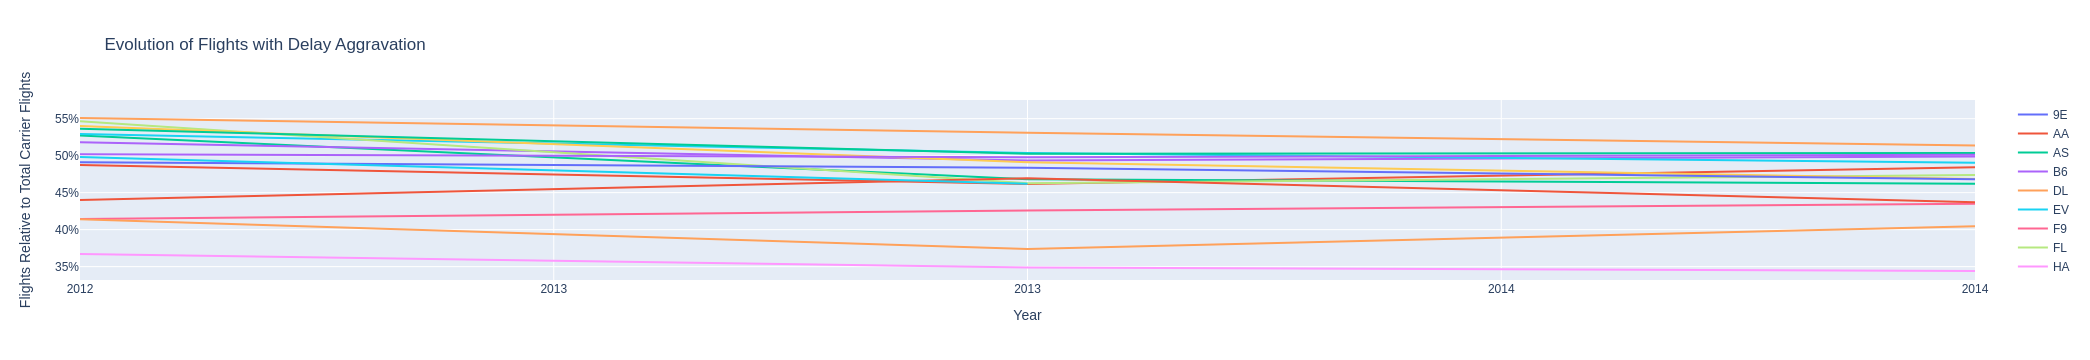

In [40]:
traces = []
changePerCarrierMap = dict()
years = []

for i in range(len(carrierDelayCountEvolution.toPandas()['Year'])):
    if not carrierDelayCountEvolution.toPandas()['Year'][i] in years:
        years.append(carrierDelayCountEvolution.toPandas()['Year'][i])

years.sort()
        
for i in range(len(carrierDelayCountEvolution.toPandas()['Carrier'])):
    if not carrierDelayCountEvolution.toPandas()['Carrier'][i] in changePerCarrierMap:
        changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]] = []
        
    changePerCarrierMap[carrierDelayCountEvolution.toPandas()['Carrier'][i]].append(carrierDelayCountEvolution.toPandas()['DelayAggravation'][i])
    
for key in changePerCarrierMap:
    traces.append(go.Scatter(
        y = changePerCarrierMap[key],
        x = years,
        mode = 'lines',
        name = key))
       
layout = dict(title = 'Evolution of Flights with Delay Aggravation',
              xaxis= dict(title= 'Year',zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Flights Relative to Total Carrier Flights',tickformat=',.0%')
             )

fig = dict(data = traces, layout = layout)

pyo.iplot(fig)